1. mirror mount positions go from 0 to 1 (or any arbitrary continuous range really)

2. ion responses go from 0 to 100 photons per measurement round (or any arbitrary , small,
integer range)

In [28]:
from typing import List, Dict, Iterator
from abc import ABC, abstractmethod
import math
from operator import itemgetter

import scipy.stats as stats
from scipy import optimize

import numpy
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


class IonSystem(ABC):
    _max_ion_response = 100

    @abstractmethod
    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        ...

    @abstractmethod
    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        ...

class GaussianIonSystem(IonSystem):
    """
    Ion System the follows a ideal gaussian curve.

    """
    def __init__(self, peak_location: float, variance: float):
        # define constants
        self.peak_location: float = peak_location
        self.variance: float = variance
        self.pos: float = 0.

    @property
    def sigma(self) -> float:
        return math.sqrt(self.variance)

    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        self.pos = pos

    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        return round(
            self._max_ion_response *
            stats.norm.pdf(self.pos, self.peak_location, self.sigma)
            )

class MeasureControlSystem(ABC):
    """
    Base class to define generating sequence of positions to pick and how to pick the result.
    
    """

    #keep track of what was recorded.
    previous_positions: List[float]
    previous_response: List[int]
    step_index: int

    def __init__(self):
        self._initialize_search()

    def _initialize_search(self) -> None:
        self.previous_positions = []
        self.previous_response = []
        self.step_index = 0

    @abstractmethod
    def pick_best_position(self) -> float:
        """
        return the best position based off the points collected.

        """
        ...

    @abstractmethod
    @property
    def search_complete(self) -> bool:
        """
        Return true when search is complete.

        """
        ...

    def next_position(self) -> float:
        """
        Private next postiion that also records the point.

        """
        cur_pos = self._next_position()
        self.previous_positions.append(cur_pos)
        self.step_index += 1
        return cur_pos

    @abstractmethod
    def _next_position(self) -> float:
        """
        Iterator to produce points.

        """
        ...

    def record_response(self, response: float) -> None:
        """
        Record what the response was for the previous points.

        Points must be recorded in the order measured.
        
        """
        self.previous_response.append(response)

    def __iter__(self) -> Iterator[float]:
        self._initialize_search()
        return self

    def __next__(self) -> float:
        if self.search_complete:
            raise StopIteration
        return self.next_position()


class LinearSearchGaussianPicker(MeasureControlSystem):
    """
    Measure control system that does a linear search (scan) and picks the best position based off a gaussian fit.

    """

    def __init__(self, num_steps = 100):
        self.num_steps = 100
        self._positions = numpy.linspace(0,1,self.num_steps)

    @abstractmethod
    def pick_best_position(self) -> float:
        """
        This picker assumes a gaussian curve, so we use a fit match to that.
        
        """
        ion_response_list = zip(self.previous_positions, self.previous_response)
        first_guess_mean = sorted(ion_response_list, key = itemgetter(1), reverse=True)[0][0]

        def gaussian(x, amplitude, mean, stddev):
            return amplitude * numpy.exp(-((x - mean) / 4 / stddev)**2)

        (_, mean, _), _ = optimize.curve_fit(gaussian, self.previous_positions, self.previous_response, p0=[100, first_guess_mean, 1])
        return mean

    @abstractmethod
    @property
    def search_complete(self) -> bool:
        """
        Return true when search is complete.

        """
        return self.previous_positions >= self.num_steps

    @abstractmethod
    def _next_position(self) -> float:
        """
        Iterator to produce points based off what has been recorded.

        """
        return self._positions[self.step_index]

In [21]:
def scan_example(ion_system: IonSystem, measure_controler: MeasureControlSystem) -> float:
    """
    Return the optimal position.

    """
    move_mirror_to_position = ion_system.move_mirror_to_position
    measure_ion_response = ion_system.measure_ion_response
    start = 0
    stop = 1
    step = .01

    ion_responses: Dict[float, int] = {}
    for pos in numpy.arange(start, stop, step):
        move_mirror_to_position(pos)
        ion_response = measure_ion_response()
        ion_responses[pos] = ion_response
    return pick_best_position(ion_responses)



In [22]:
def evaluate_locator(
        cur_ion_sys: IonSystem, 
        pick_best_position: PickBestPositionT,
        expected_position: float,
        ) -> float:
    """
    Evaluate how good the method is.
    
    """
    scan_result = scan_example(cur_ion_sys, pick_best_position)
    error = abs(scan_result - expected_position)
    return error

def plot_evaluation(
        cur_ion_sys: IonSystem, 
        pick_best_position: PickBestPositionT,
        expected_position: float,
        ) -> Figure:
    """
    Evaluate how good the method is.
    
    """

    scan_result = scan_example(cur_ion_sys, pick_best_position)
    error = abs(scan_result - expected_position)
    
    ion_responses: List[int] = []
    pos_scan = numpy.arange(0, 1, .0001)
    for pos in pos_scan:
        cur_ion_sys.move_mirror_to_position(pos)
        ion_response = cur_ion_sys.measure_ion_response()
        ion_responses.append(ion_response)

    fig, axes = plt.subplots(1,1)
    axes.plot(pos_scan, ion_responses, label="Measured Response")
    axes.axvline(scan_result, color='blue', label='Peak Detect')
    axes.axvline(expected_position, linestyle='dashed', color='gray', label='Peak Actual')
    # dont use percent error because peak could be near zero.
    axes.set_title(f'Error: {error:.02f}')
    axes.legend()
    return fig


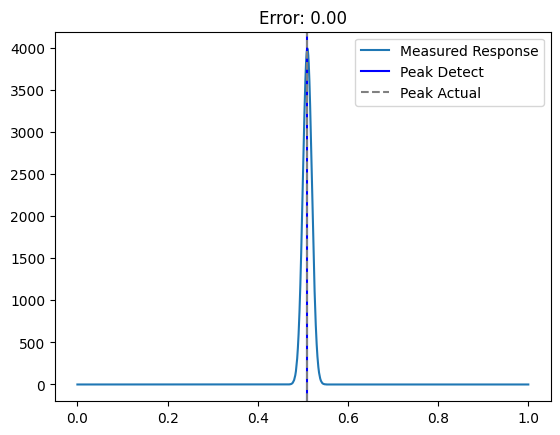

In [24]:
peak_location = .51
variance=.0001
cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)

fig = plot_evaluation(
    cur_ion_sys=cur_ion_sys,
    pick_best_position=gaussian_pick_best_position,
    expected_position=peak_location,
    )

fig.show()

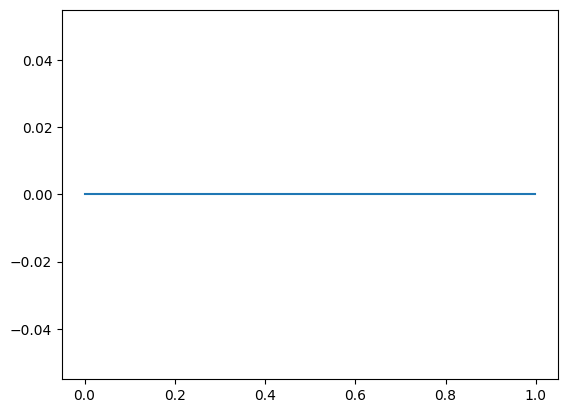

In [27]:
peak_locations = numpy.arange(0, 1, .001)
error: List[float] = []
for cur_peak_location in peak_locations:
    variance=.0001
    cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)

    error.append(evaluate_locator(
        cur_ion_sys=cur_ion_sys,
        pick_best_position=gaussian_pick_best_position,
        expected_position=peak_location,
        ))

fig, axes = plt.subplots(1,1)
axes.plot(peak_locations, error)
fig.show()